c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\zln92\AppData\Local\Temp\ipykernel_14176\3929906740.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probabilities, y=category_names, ax=ax, palette='viridis')


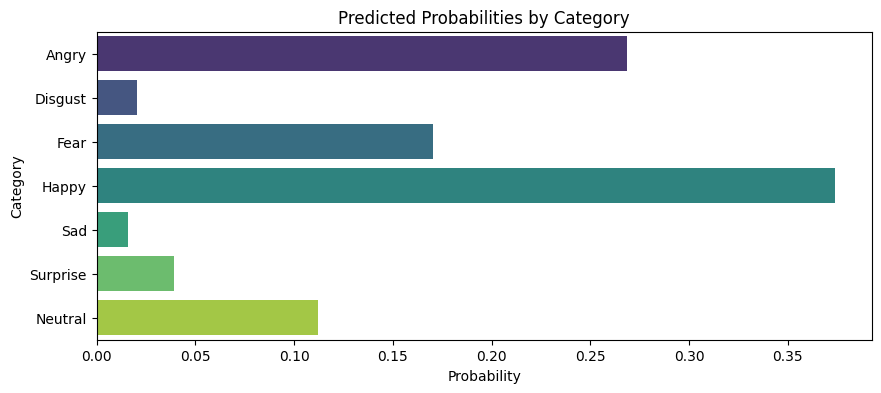

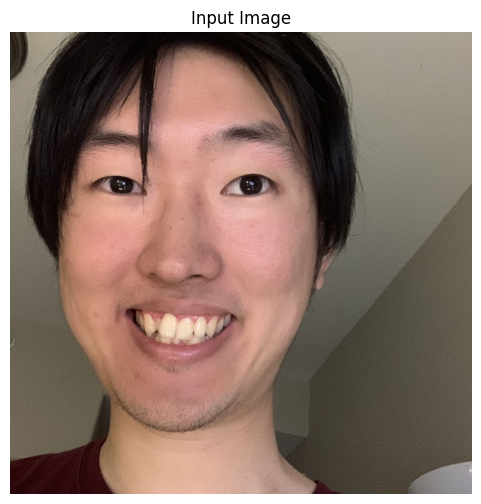

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTForImageClassification
import torch.nn.functional as F
from torchviz import make_dot

image_path = "c109dad311653f58006de4f4da1f345.jpg"

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

input_dim = model.classifier.in_features
num_classes = 7

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x

model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

model.load_state_dict(torch.load('HuggingFaceTransformer_V1_6_weights_test2.pth'))
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()  
    image = transform(image).unsqueeze(0)  
    return image, original_image

def predict_image(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor).logits
        probabilities = F.softmax(outputs, dim=1).cpu().numpy().flatten()
    return probabilities

def plot_probabilities(probabilities, category_names):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x=probabilities, y=category_names, ax=ax, palette='viridis')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Category')
    ax.set_title('Predicted Probabilities by Category')
    plt.show()

def show_image(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

image_tensor, original_image = preprocess_image(image_path)

probabilities = predict_image(model, image_tensor)

plot_probabilities(probabilities, category_names)

show_image(original_image)


In [9]:
# Display the architecture of the model
print(model)

# Visualize the architecture
dummy_input = torch.zeros(1, 3, 224, 224).to(device)
output = model(dummy_input).logits  # Extract the logits tensor
model_viz = make_dot(output, params=dict(model.named_parameters()))
model_viz.format = 'png'
model_viz.render('model_architecture_detail')

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

'model_architecture_detail.png'

In [3]:
from graphviz import Digraph

# Function to visualize the model architecture
def visualize_model(model):
    dot = Digraph()
    dot.node('Pretrained Model', 'Pretrained ViT Model')
    
    for i, layer in enumerate(model.classifier.children()):
        dot.node(f'Layer_{i}', f'{layer}')
        if i == 0:
            dot.edge('Pretrained Model', f'Layer_{i}')
        else:
            dot.edge(f'Layer_{i-1}', f'Layer_{i}')
    
    return dot

# Visualize the architecture
visualization = visualize_model(model)
visualization.render('model_architecture', format='png', cleanup=True)
visualization.view()

'model_architecture.pdf'

In [8]:
from torchsummary import summary
import pandas as pd


# Summary part
def get_layer_params(layer):
    return sum(p.numel() for p in layer.parameters() if p.requires_grad)

summary_data = []

# Add the pretrained model as one block
pretrained_params = get_layer_params(model.vit)
summary_data.append(['Pretrained ViT Model', '-', '-', pretrained_params])

# Add the custom classifier layers
for name, layer in model.classifier.named_children():
    layer_name = type(layer).__name__
    layer_params = get_layer_params(layer)
    layer_size = tuple(layer.weight.size()) if hasattr(layer, 'weight') else 'N/A'
    summary_data.append([name, layer_name, layer_size, layer_params])

# Create a DataFrame for better visualization
df_summary = pd.DataFrame(summary_data, columns=['Layer', 'Type', 'Size', 'Num Parameters'])

# Display the summary table
print(df_summary)

# Calculate and display the total number of parameters
total_params = df_summary['Num Parameters'].sum()
print(f'Total number of parameters: {total_params}')

                  Layer     Type        Size  Num Parameters
0  Pretrained ViT Model        -           -        85798656
1                   fc1   Linear  (512, 768)          393728
2                   fc2   Linear  (256, 512)          131328
3                   fc3   Linear  (128, 256)           32896
4                   fc4   Linear   (64, 128)            8256
5                   fc5   Linear     (7, 64)             455
6               dropout  Dropout         N/A               0
7                  relu     ReLU         N/A               0
Total number of parameters: 86365319
